# Q1 Gabarito

Vamos desenvolver a análise usando o Jupyter Notebook e depois incluiremos as funções desenvolvidas no código Python

In [1]:
# Imports e preâmbulos
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils #pip install imutils
import os
import math

%matplotlib inline

print("Versão da OpenCV ", cv2.__version__)
print("Estamos no diretório ", os.getcwd())
print("Listagem: ", os.listdir())

# Função auxiliar para plot

def multiplot(imgs, legenda="No sub"):
    """ Função """
    fig, axes = plt.subplots(1,len(imgs), figsize=(24,8))    
    fig.suptitle(legenda)
    if len(imgs)==1: # Peculiaridade do subplot. Não é relevante para a questão
        ax = axes
        ax.imshow(cv2.cvtColor(imgs[0], cv2.COLOR_BGR2RGB))
        return
    for i in range(len(imgs)):
        axes[i].imshow(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB))

def everyplot(img, legenda):
    """Faz o multiplot de 1 em 1 """
    i = 1
    for m in img:
        multiplot([m], "{} {}".format(legenda, i))
    i+=1
        
def multiplot_gray(imgs, legenda):
    """ Função que plota n imagens grayscale em linha"""
    fig, axes = plt.subplots(1,len(imgs), figsize=(26,8))    
    fig.suptitle(legenda)
    if len(imgs)==1: # Peculiaridade do subplot. Não é relevante para a questão
        ax = axes
        ax.imshow(cv2.cvtColor(imgs[0],  vmin=0, vmax=255, cmap="Greys_r"))
        return
    for i in range(len(imgs)):
        axes[i].imshow(imgs[i], vmin=0, vmax=255, cmap="Greys_r")

def auto_canny(image, sigma=0.33):
    """Função vinda da aula 2"""
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    # return the edged image
    return edged

def crosshair(img, point, size, color, width=5):
    """ 
        Função vinda da aula 2
        Desenha um crosshair centrado no point.
        point deve ser uma tupla (x,y)
        color é uma tupla R,G,B uint8
    """
    x,y = point
    cv2.line(img,(x - size,y),(x + size,y),color,width)
    cv2.line(img,(x,y - size),(x, y + size),color,width)



Versão da OpenCV  4.4.0
Estamos no diretório  /Users/mirwox/Dropbox/Insper/2016/Robotics/src/202_robot_p1/q1
Listagem:  ['saveframes.py', 'Q1.ipynb', 'q1.py', '.DS_Store', 'angles_orientation.png', 'gimp_point.jpg', 'out', 'relogio.mp4', '.gitattributes', '.ipynb_checkpoints', 'relogio01.jpg', 'relogio03.jpg', 'color_wheel.jpg', 'relogio02.jpg', 'esquema_angulos.png', 'relogio06.jpg', 'relogio07.jpg', 'relogio05.jpg', 'relogio04.jpg']


Salvamos alguns frames do vídeo para fins ilustrativos neste notebook

In [2]:
filenames = "relogio01.jpg relogio03.jpg relogio05.jpg relogio07.jpg relogio02.jpg relogio04.jpg relogio06.jpg".split()
# filenames = "relogio01.jpg  relogio05.jpg relogio07.jpg".split()

In [3]:
# Lembrando que os frames serão lidos por default in BGR
frames = [cv2.imread(f) for f in filenames]

# Criação dos mesmos em HSV para conveniência
hsv = [cv2.cvtColor(f, cv2.COLOR_BGR2HSV) for f in frames]

# Em cinza
#grays = [cv2.cvtColor(f, cv2.COLOR_BGR2GRAY) for f in frames]

# Bordas
#cannys = [auto_canny(g) for g in grays]


Vamos visualizar alguns frames

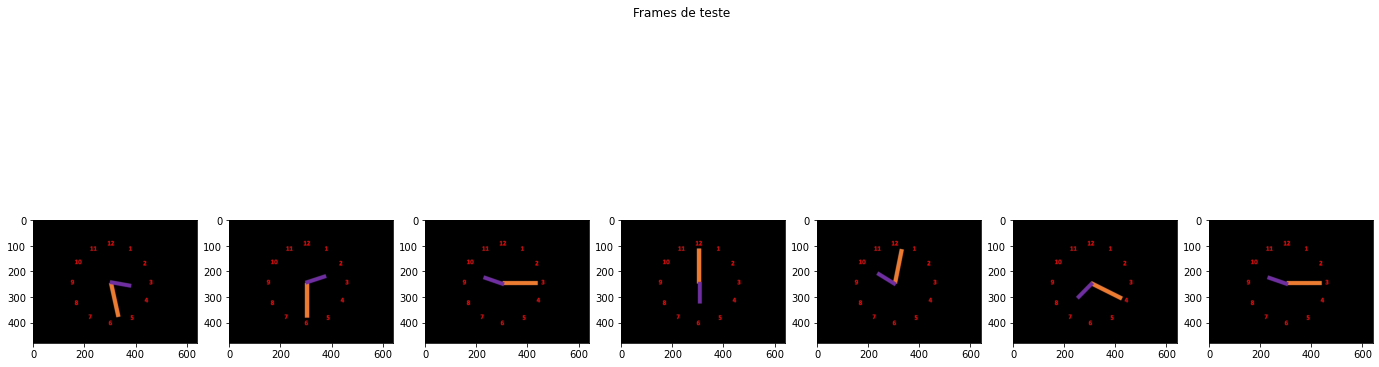

In [4]:
multiplot(frames, "Frames de teste")

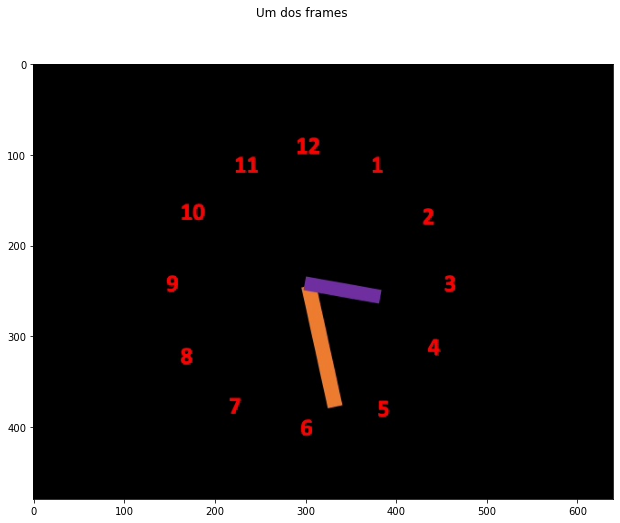

In [5]:
multiplot([frames[0]], "Um dos frames")

Precisamos definir os intervalos de cores para a filtragem e criação de máscaras. Poderíamos seguir o método que usa `aux.ranges` mas preferi neste caso me basear diretamente no círculo de cores:

<img src="./color_wheel.jpg" width=50%>\

Lembrando que:

* Nas ferramentas gráficas a componente H vai de $0$ a $360$ e precisa ser dividido por 2 para usar na OpenCV
* A componente S vai do branco até a tonalidade correta da cor, e nas ferramentas fica na faixa $[0\% - 100\%]$. Na OpenCV precisa ser convertido para $[0-255]$. 
* A componente V vai do preto até a tonalidade correta da cor, e nas ferramentas fica na faixa $[0\% - 100\%]$. Na OpenCV precisa ser convertido para $[0-255]$. 

Normalmente para cores que não são nem muito claras nem muito escuras, mantemos nesta disciplina valores de S e V na faixa $[50-255]$

### Função filtro

A partir da análise do círculo de cores criamos filtros para as cores dos dois ponteiros

In [6]:
def filter(HSV, menor, maior):
    cor1 = np.array(menor, dtype=np.uint8)
    cor2 = np.array(maior, dtype=np.uint8)
    return cv2.inRange(HSV, cor1, cor2)

# Não precisa do filtro vermelho para resolver a questão!
def filter_red(hsv):
    menor = [0, 50, 100]
    maior = [4, 255,255]
    return filter(hsv, menor, maior)    
    
def filter_purple(hsv):
    menor = [125, 50, 50]
    maior = [145, 255,255]
    return filter(hsv, menor, maior)     
    
def filter_orange(hsv):
    menor = [8, 50, 50]
    maior = [34, 255,255]
    return filter(hsv, menor, maior)
    

## Testando os filtros

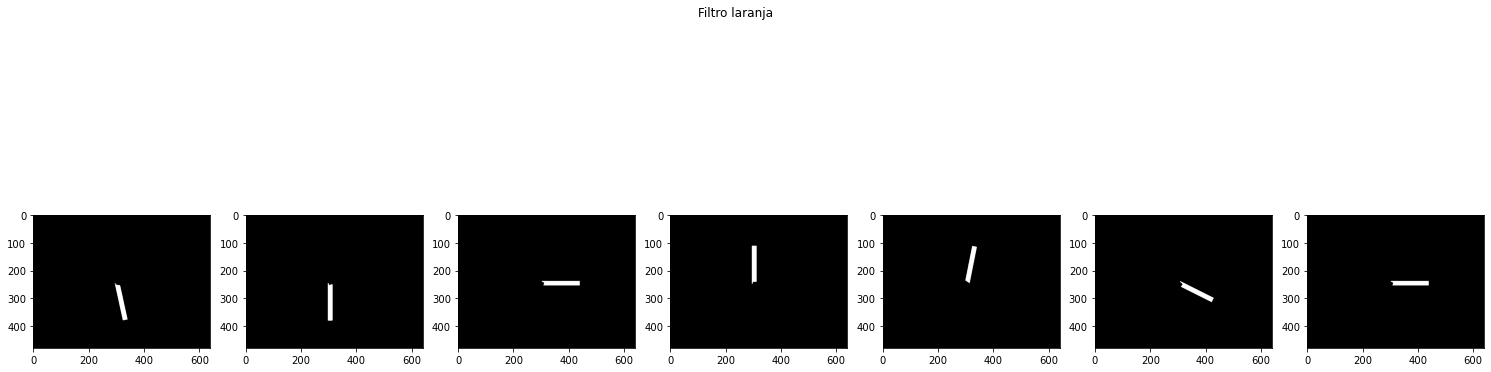

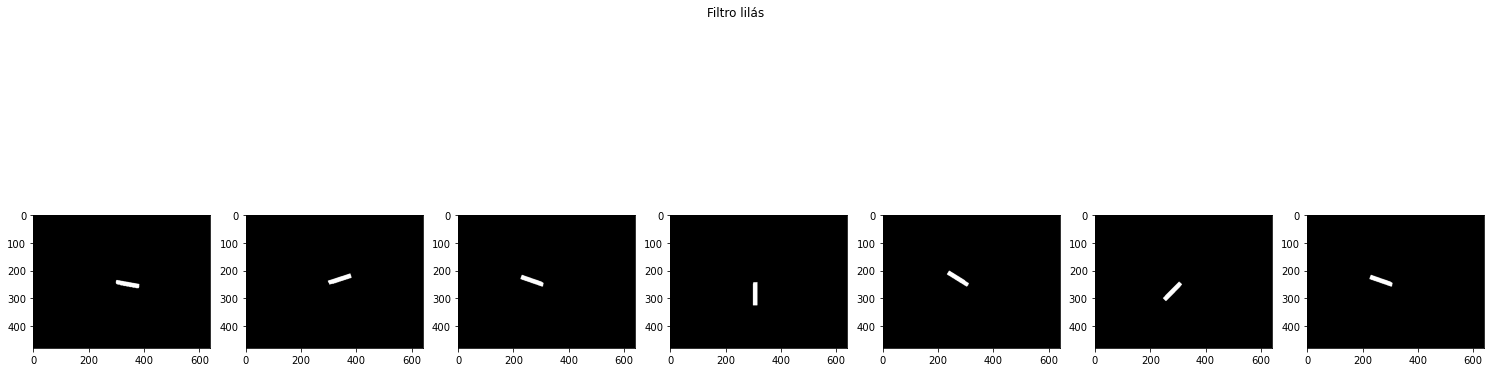

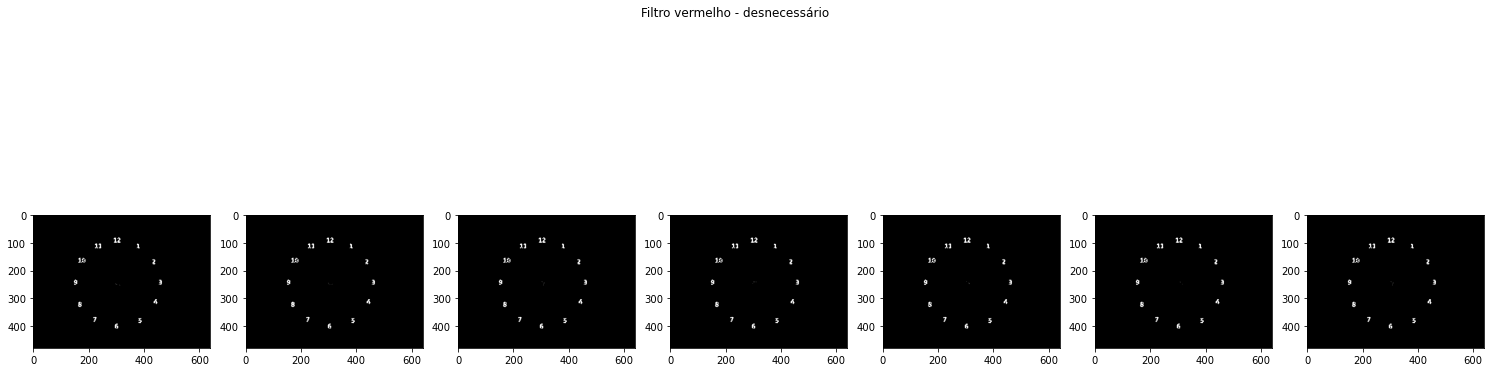

In [7]:
oranges = [filter_orange(h) for h in hsv]
purples = [filter_purple(h) for h in hsv]
reds = [filter_red(h) for h in hsv]

multiplot_gray(oranges, "Filtro laranja")
multiplot_gray(purples, "Filtro lilás")
multiplot_gray(reds, "Filtro vermelho - desnecessário")

No exemplo acima o filtro vermelho não é necessário para resolver a questão

## Determinando o centro do relógio

Caso apliquemos a transformada de `HoughLinesP`, obteremos como resultado os diversos segmentos de retas contidos na imagem. Nos ajuda se soubermos para cada segmento qual é o ponto próximo ao centro do relógio e qual é o mais distante.

Note que o corpo do relógio nunca se move, apenas os ponteiros. Então podemos capturar um *frame* congelado no tempo e identificar o centro nele. 

A partir dos plots acima vemos que o centro seria numa posição $(x,y)$ aproximadamente em $(300, 240$. Vamos apenas procurar conhecer esta posição com mais precisão.

Note que se você estiver no Linux o próprio cursor na janela da OpenCV já vai mostrar a posição na base da janela.

Nós vamos executar o programa Gimp que pode ser executado ao digitar o comando `gimp` em qualquer terminal.

<img src="./gimp_point.jpg" width=60%>

Usando o cursor do Gimp vemos que o ponto central é aproximadamente $c = (x_c, y_c) = (305, 246)$

  

## Resolução do problema

A partir de agora seguiremos o seguinte plano:

* Aplicar HoughLinesP à imagem
* Descobrir o ângulo
* Converter em horas ou minutos conforme o ponteiro


### HoughLinesP

In [8]:

def dist(p1, p2):
    return np.sqrt(math.pow((p1[0] - p2[0]),2) + math.pow((p1[1]-p2[1]), 2))

def mais_perto_primeiro(referencia, p1, p2):
    """ Aceita 3 pontos: referencia e p1 e p2 e devolve dois pontos com o mais próximo da referencia primeiro"""
    if dist(referencia, p1) < dist(referencia, p2):
        return p1,p2
    else:
        return p2,p1
    

def apply_hough(gray, color_bgr =(255, 0, 0), centro=(305, 246), output_img=None):
    """
        Função hough modificada que devolve os pontos do segmento de reta sempre com o mais distante do centro primeiro
    """
    hough_img = gray
    lines = cv2.HoughLinesP(hough_img, 10, math.pi/180.0, 100, np.array([]), 45, 5)
   
    #if lines is None or len(lines)==0:
    #    return []
    
    a,b,c = lines.shape
    
    
    lines_out = []

                           
    for i in range(a):
        # Faz uma linha ligando o ponto inicial ao ponto final, com a cor vermelha (BGR)
        p1 = (lines[i][0][0], lines[i][0][1])
        p2 = (lines[i][0][2], lines[i][0][3])

        if output_img is not None:
            cv2.line(output_img, p1, p2, color_bgr , 1, cv2.LINE_AA)
            
        lines_out.append(mais_perto_primeiro(centro, p1,p2))
        
    return lines_out
        

def media_segundo_ponto(lista_p1_p2):
    """
        Devolve a média do segundo ponto das tuplas encontradas por hough
    """
    l = lista_p1_p2
    #print(l)
    x = y = 0
    for segmento in l:
        x+=segmento[1][0]
        y+=segmento[1][1]
    n = len(l)
    return int(x/n), int(y/n)
    

def media_crosshair(lista, imagem_bgr, color_cross):
    """
        A partir de uma lista de pontos recebida a partir de hough e desenha um crosshair 
    """
    c = media_segundo_ponto(lista)
    crosshair(imagem_bgr, c, 10, color_cross)
    return c
        
    
        

Vamos recordar os parâmetros da função HoughLinesP

In [9]:
help(cv2.HoughLinesP)

Help on built-in function HoughLinesP:

HoughLinesP(...)
    HoughLinesP(image, rho, theta, threshold[, lines[, minLineLength[, maxLineGap]]]) -> lines
    .   @brief Finds line segments in a binary image using the probabilistic Hough transform.
    .   
    .   The function implements the probabilistic Hough transform algorithm for line detection, described
    .   in @cite Matas00
    .   
    .   See the line detection example below:
    .   @include snippets/imgproc_HoughLinesP.cpp
    .   This is a sample picture the function parameters have been tuned for:
    .   
    .   ![image](pics/building.jpg)
    .   
    .   And this is the output of the above program in case of the probabilistic Hough transform:
    .   
    .   ![image](pics/houghp.png)
    .   
    .   @param image 8-bit, single-channel binary source image. The image may be modified by the function.
    .   @param lines Output vector of lines. Each line is represented by a 4-element vector
    .   \f$(x_1, y_1, x_2, y

# Deteção do ponteiro laranja dos minutos

In [10]:
orange_lines_bgr = [f.copy() for f in frames]

In [11]:
for i in range(len(orange_lines_bgr)):
    output = []
    linhas = apply_hough(oranges[i], output_img=orange_lines_bgr[i])
    media_crosshair(linhas, orange_lines_bgr[i], (0,255,255))
    

Note que o que aparece em azul é o traço das linhas achadas por HoughLinesP

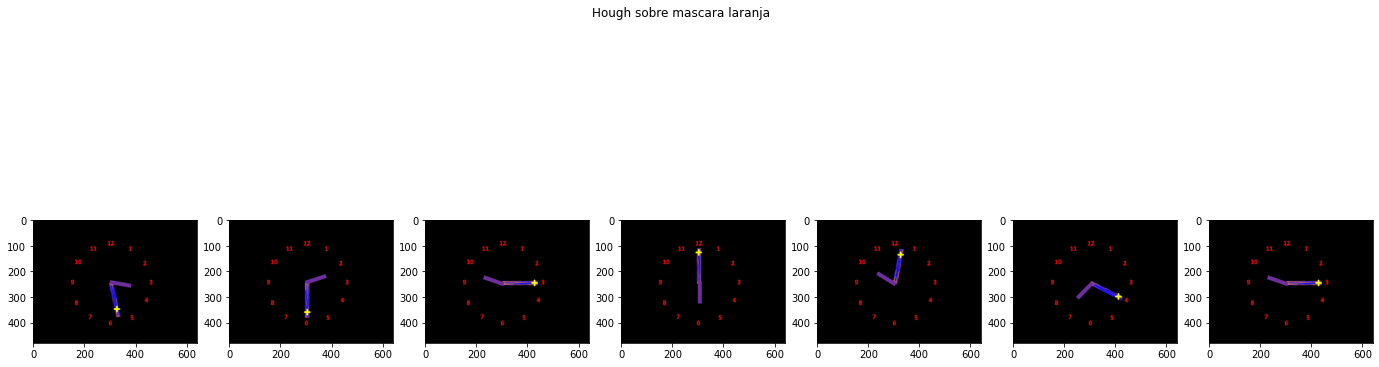

In [12]:
multiplot(orange_lines_bgr, "Hough sobre mascara laranja")

# Deteção do ponteiro roxo das horas

In [13]:
purple_lines_bgr = [f.copy() for f in frames]

In [14]:
for i in range(len(purple_lines_bgr)):
    output = []
    linhas = apply_hough(purples[i], output_img=purple_lines_bgr[i])
    media_crosshair(linhas, purple_lines_bgr[i], (255,255,255))

Note que o que aparece em azul é o traço das linhas achadas por HoughLinesP

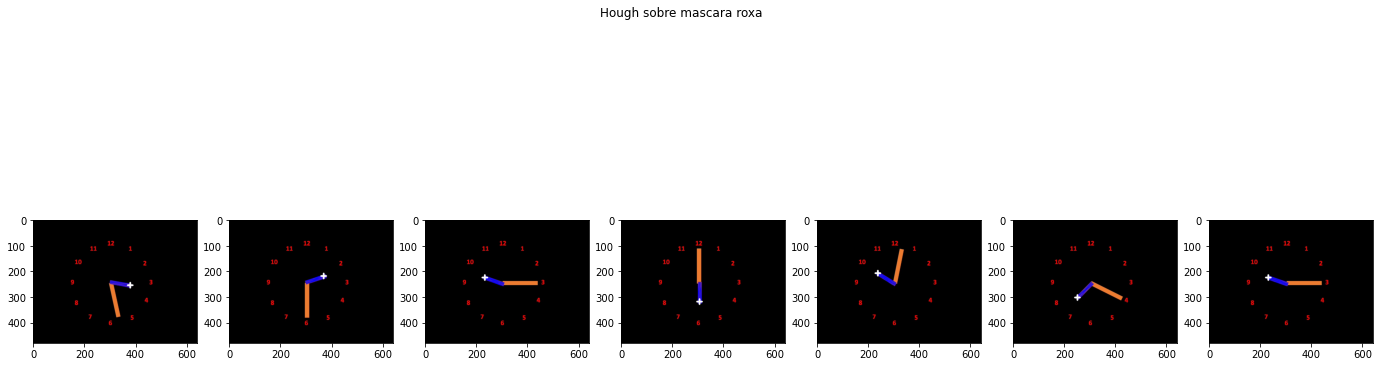

In [15]:
multiplot(purple_lines_bgr, "Hough sobre mascara roxa")

Vamos ver um dos elementos no detalhe

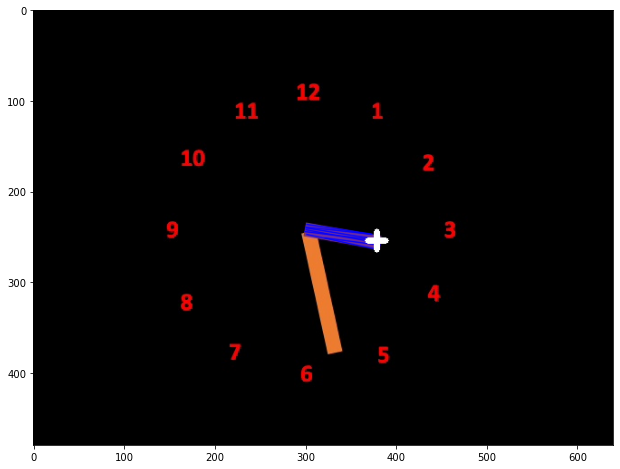

In [16]:
multiplot([purple_lines_bgr[0]], "")

## Ângulos e horas

<img src="esquema_angulos.png" width=50%>

Primeiro recordemos que em imagens o eixo $x$ costuma ser horizontal e o eixo $y$ é vertical apontando para baixo. 

O quanto pudermos nos beneficiar do esquema default de coordenadas, melhor.

Neste esquema os  ângulos que se formam partindo do eixo $x$ em direção ao eixo $y$ já serão naturalmente no sentido horário.

Precisamos só lembrar que o relógio conta as horas e minutos a partir da posição 12. O sistema de eixos da figura a partir da  horizontal que seria a posição $3$ horas para o ponteiro das horas e $15$ minutos para o outro ponteiro. Desta forma, é necessário sempre subtrair $90^o$ do resultado. 


Segundo a figura acima, precisamos calcular o ângulo da seguinte forma:


$$\alpha=atan(\frac{\Delta_{vertical}}{\Delta_{horizontal}}) - 90^o$$$

Em que:

$$\Delta_{horizontal} = x_{pont} - x_{c}$$

e

$$\Delta_{vertical} = y_{pont} - y_{c}$$

Nestas equações $(x_{c}, y_{c})$ é o centro do relógio, ou seja (305, 246)

O ponto $x_{pont}, y_{pont}$ corresponde à média dos pontos extremos encontrados pela transformada de Hough e calculada pela função `media_crosshair`


## Estudo da função tangente

*Mas antes* de proceder vale a pena também fazer um estudo da função tangente

In [17]:
x = np.linspace(0, 2*math.pi, 1000)
x_graus = np.degrees(x)
y = np.tan(x)

In [18]:
def plot_tan(oposto, adjacente):
    ang = math.atan2(oposto, adjacente)
    ang_graus = math.degrees(ang)
    tang = math.tan2(oposto, adjacente)
    x = np.linspace(0, 2*math.pi, 1000)
    x_graus = math.degrees(x)
    y = np.tan(x)
    val = np.tan(0.95*np.pi/2)
    plt.ylim(-val,val)
    plt.plot(x_graus,y)
    plt.axhline(tang)
    plt.axvline(ang_graus, color="r", linestyle="--")



Text(0.5, 1.0, 'Função tangente entre $0$ e $2\\pi$ \n linha vermelha em $\\pi$')

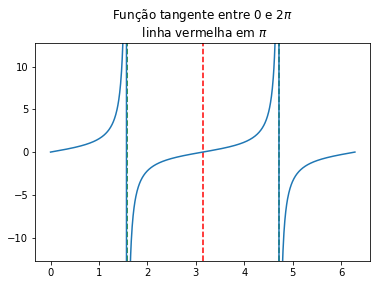

In [19]:
val = np.tan(0.95*np.pi/2)
plt.axvline(math.pi, linestyle="--", color="r")
plt.axvline(math.pi/2, linestyle="--", color="g")
plt.axvline(3*math.pi/2, linestyle="--", color="g")

plt.ylim(-val,val)
plt.plot(x,y)
plt.title("Função tangente entre $0$ e $2\pi$ \n linha vermelha em $\pi$")

Em graus

Text(0.5, 1.0, 'Função tangente entre $0$ e $360^{o}$ \n linha vermelha em $180^{o}$')

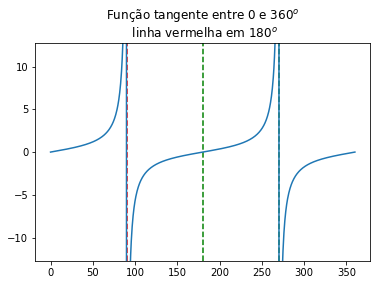

In [20]:
val = np.tan(0.95*np.pi/2)
plt.axvline(90, linestyle="--", color="r")
plt.axvline(180, linestyle="--", color="g")
plt.axvline(270, linestyle="--", color="g")
plt.ylim(-val,val)
plt.plot(x_graus,y)
plt.title("Função tangente entre $0$ e $360^{o}$ \n linha vermelha em $180^{o}$")

Notemos que a função 

In [21]:
def delta(centro, ponteiro):
    """
        Recebe o centro da imagem e a ponta do ponteiro e calcula os deltas verticais e horizontais conforme
        imagem presente no gabarito
    """
    x = 0
    y = 1
    delta_horizontal = ponteiro[x] - centro[x]
    delta_vertical = ponteiro[y] - centro[y]
    return delta_horizontal, delta_vertical

def old_angulo(delta_horizontal, delta_vertical):
    """A partir do delta horizontal e vertical calcula o angulo"""
    # Note que como estamos calculando o angulo em relação a 12horas, na verdade é horizontal, vertical
    # if delta_horizontal > 0:
    #     return math.atan2(delta_horizontal, delta_vertical)
    # else:
    #    return math.pi+math.atan2(delta_horizontal, delta_vertical) 
    if delta_horizontal >= 0:
        return math.atan2(delta_horizontal, delta_vertical)
    else: 
        return math.pi + math.atan2(delta_horizontal,-delta_vertical)    

def angulo(delta_vertical, delta_horizontal):
    """A partir do delta horizontal e vertical calcula o angulo"""
    # Note que como estamos calculando o angulo em relação a 12horas, na verdade é horizontal, vertical
    # if delta_horizontal > 0:
    #     return math.atan2(delta_horizontal, delta_vertical)
    # else:
    #    return math.pi+math.atan2(delta_horizontal, delta_vertical) 
    #return (math.atan2(delta_vertical, delta_horizontal) + 3.0*math.pi/2.0)%(2*math.pi)
    return (math.atan2(delta_vertical, delta_horizontal) + 5.0*math.pi/2.0)%(2*math.pi)
    
    

    
def minutos(angulo):
    """A partir do angulo encontra os minutos"""
    um_minuto = 2*math.pi/60.0
    return int(angulo/um_minuto)
    
    
def horas(angulo):
    """A partir do angulo encontra as horas
    """
    uma_hora = 2*math.pi/12.0
    return int(angulo/uma_hora)
    
def desenha_horario(bgr, horas, minutos):
    """ Recebe uma imagem BGR, horas e minutos e desenha o horario"""
    font = cv2.FONT_HERSHEY_SIMPLEX
    pos = (300,400)
    fontscale=2
    color=(0,255,255)
    thickness=3
    mensagem = "{:02d}:{:02d}".format(int(horas), int(minutos))
    cv2.putText(bgr, mensagem, pos, font, fontscale, color, thickness, cv2.LINE_AA) 
    
def desenha_angulo(bgr, ang_horas, ang_minutos):
    """ Recebe uma imagem BGR, horas e minutos e desenha os angulos"""
    horas = math.degrees(ang_horas)
    minutos = math.degrees(ang_minutos)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    pos = (300,150)
    fontscale=2
    color=(255,255,255)
    thickness=3
    mensagem = "{:2d}:{:2d} graus".format(int(horas), int(minutos))
    cv2.putText(bgr, mensagem, pos, font, fontscale, color, thickness, cv2.LINE_AA) 
    
def text_cv(bgr, pos, text, fontscale=1, thickness=1):
    font = cv2.FONT_HERSHEY_SIMPLEX    
    color=(255,255,255)    
    mensagem = "{}".format(text)
    cv2.putText(bgr, mensagem, pos, font, fontscale, color, thickness, cv2.LINE_AA) 
    


## Tudo junto para a solução

Vamos juntar todas as partes para, a partir de uma imagem BGR chegar às horas em minutos e segundos

In [22]:
c = (305,246)
# c = (246, 305)
centro = c
h = 0 # horizontal
v = 1 # vertical

def horario_from_bgr(bgr):
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    
    hours_purple = filter_purple(hsv)
    minutes_orange = filter_orange(hsv)
    
    list_hours = apply_hough(hours_purple, output_img=bgr)
    list_minutes = apply_hough(minutes_orange, output_img=bgr)
    ponteiro_minutes = media_crosshair(list_minutes, bgr, (255, 128,0))
    ponteiro_hours = media_crosshair(list_hours, bgr, (255, 0, 255))
    
    delta_min = delta(centro, ponteiro_minutes)
    delta_hr = delta(centro, ponteiro_hours)
    
    angulo_min = angulo(delta_min[v], delta_min[h])
    angulo_hr = angulo(delta_hr[v], delta_hr[h])
    
    desenha_angulo(bgr, angulo_hr, angulo_min)

    hr = horas(angulo_hr)
    minutes = minutos(angulo_min)
    
    desenha_horario(bgr, hr, minutes)
    
    crosshair(bgr, c, 4, (0,0,255))
    
def parte_final(bgr, centro, ponteiro_minutes):
    delta_min = delta(centro, ponteiro_minutes)
    
    angulo_min = angulo(delta_min[h], delta_min[v])
    
    desenha_angulo(bgr, 0, angulo_min)

    minutes = minutos(angulo_min)
    
    desenha_horario(bgr, 0, minutes)
    
    crosshair(bgr, c, 4, (0,0,255))

def parte_final_h(bgr, centro, ponteiro_hours):
    delta_ = delta(centro, ponteiro_minutes)
    
    angulo_min = angulo(delta_min[h], delta_min[v])
    
    desenha_angulo(bgr, 0, angulo_min)

    minutes = minutos(angulo_min)
    
    desenha_horario(bgr, 0, minutes)
    
    crosshair(bgr, c, 4, (0,0,255))

Teste final

In [23]:
bgr_cp = [img.copy() for img in frames]

In [24]:
horarios = [horario_from_bgr(f) for f in bgr_cp]

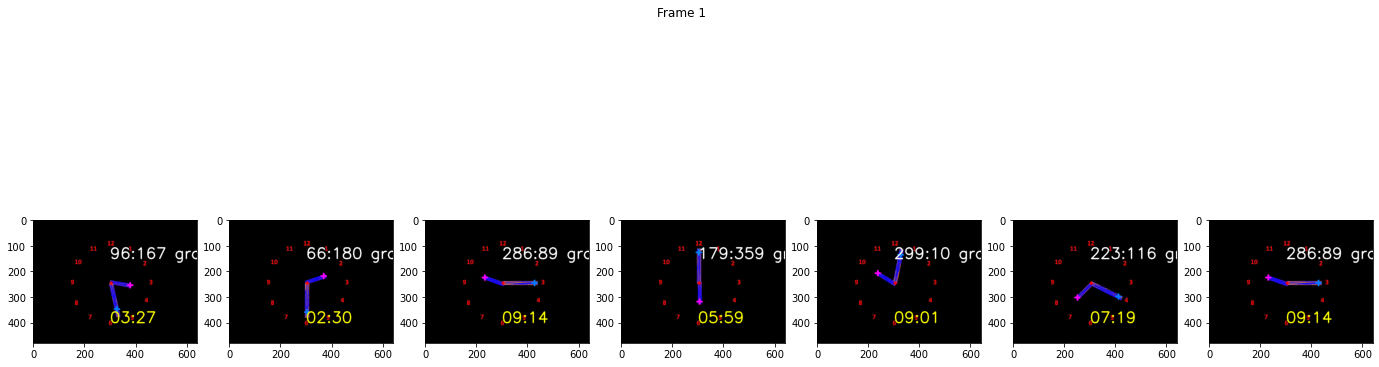

In [25]:
multiplot(bgr_cp,"Frame 1")

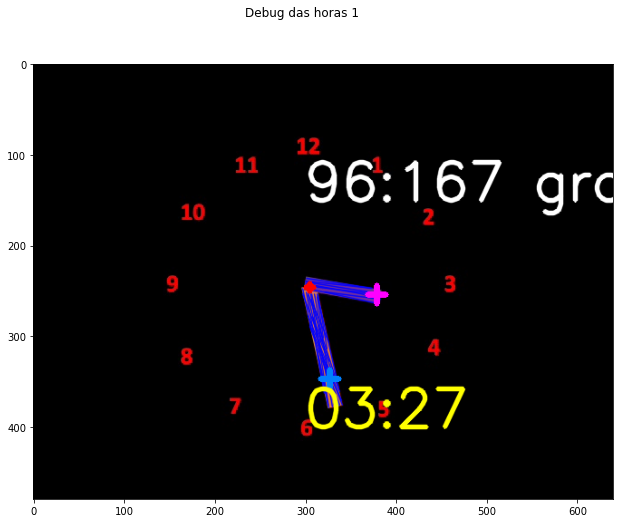

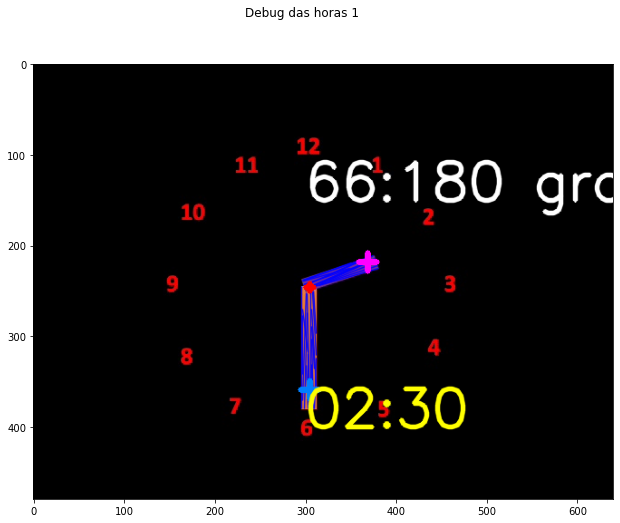

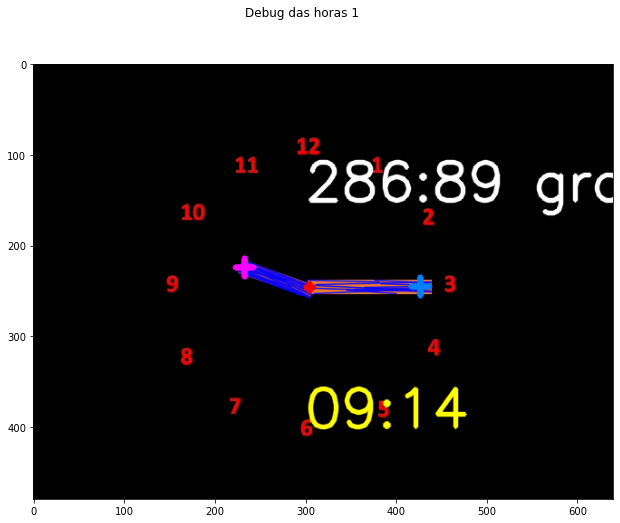

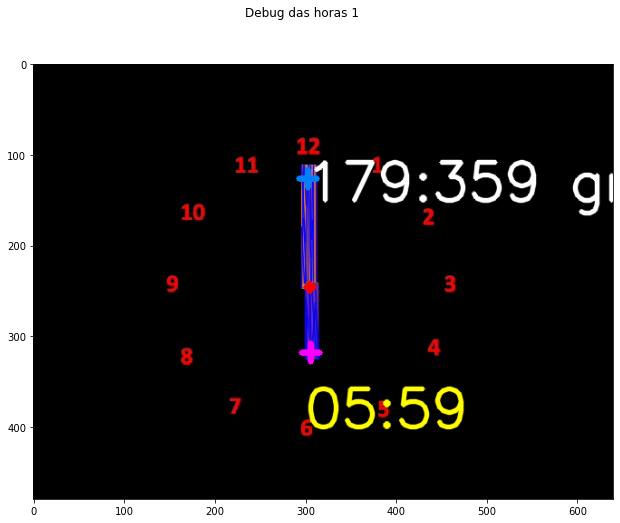

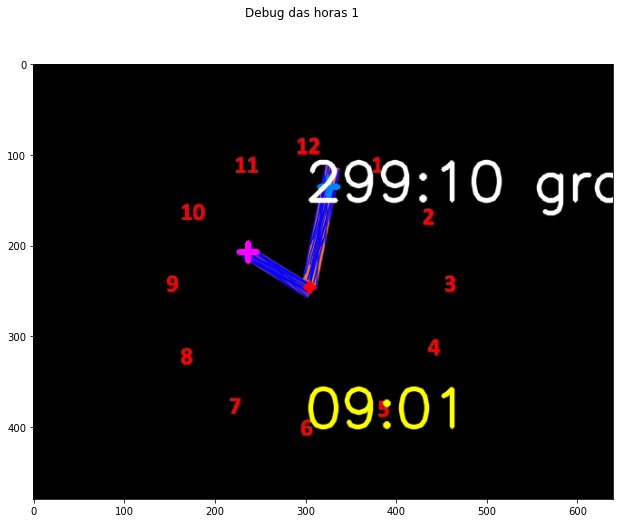

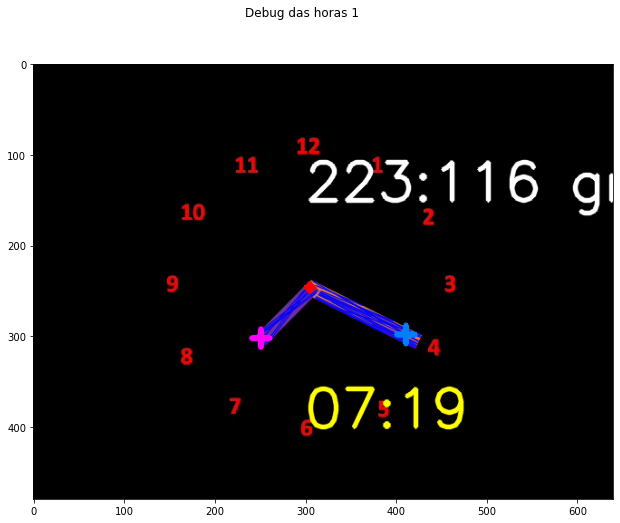

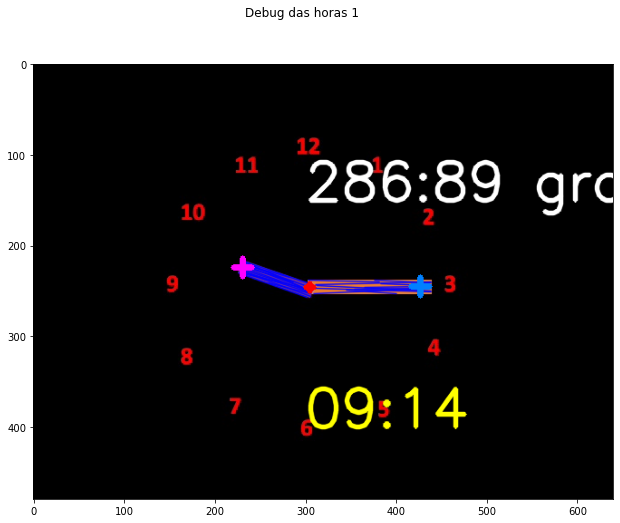

In [26]:

    everyplot(bgr_cp,"Debug das horas")

# Testes

In [27]:
template = frames[0].copy()

In [28]:
template[:] = 0
crosshair(template, c, size=6, color=(255,255,255), width=2)

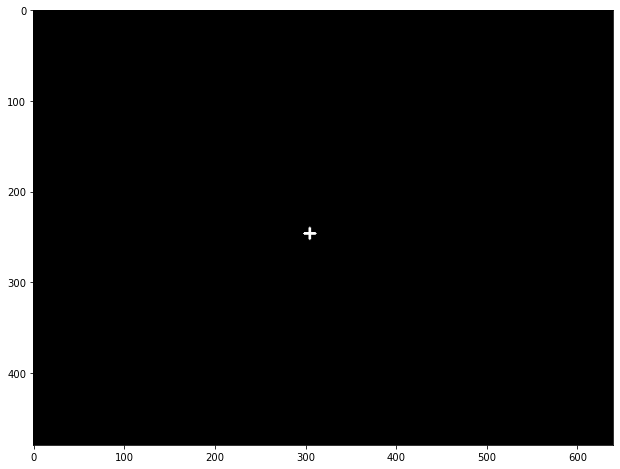

In [29]:
multiplot([template], "")

## Testando em 4 quadrantes

In [30]:
step = math.radians(45.0)

In [31]:
step

0.7853981633974483

In [32]:
angles = np.linspace(0, 2*math.pi, 9)

In [33]:
angles

array([0.        , 0.78539816, 1.57079633, 2.35619449, 3.14159265,
       3.92699082, 4.71238898, 5.49778714, 6.28318531])

In [34]:
length = 150.0

In [35]:
xcoord = [c[0] + int(length*math.cos(a)) for a in angles]

In [36]:
ycoord = [c[1] + int(length*math.sin(a)) for a in angles]

In [37]:
for p in zip(xcoord, ycoord):
    crosshair(template, p, size=4, color=(0,0,255), width=1)

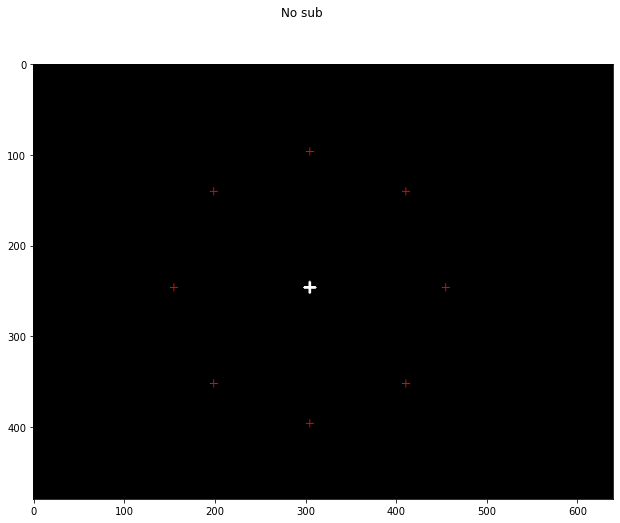

In [38]:
multiplot([template])

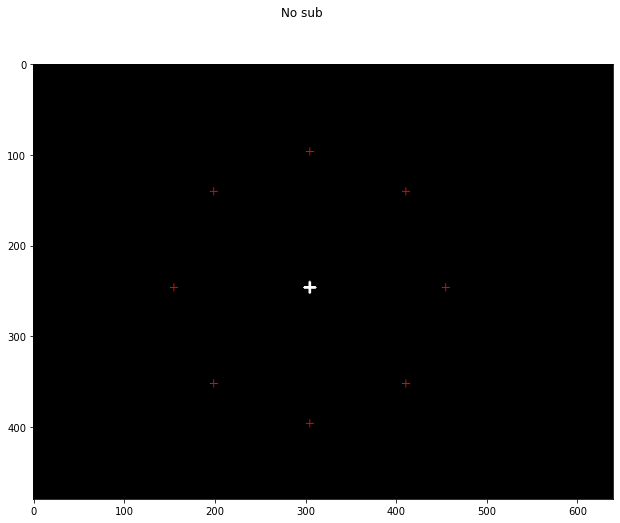

In [39]:
multiplot([template])

In [40]:
points = (list(zip(xcoord, ycoord)))

In [41]:
template[:]=0
copy = template.copy()
crosshair(copy, c, size=6, color=(255,255,255), width=2)

# Estudo dos ângulos

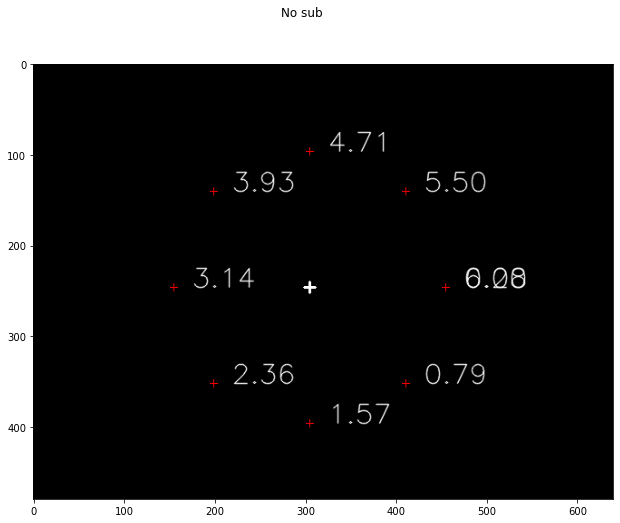

In [42]:
for i in range(len(points)):
    p = points[i]
    a = angles[i]
    text_cv(copy, (p[0]+20, p[1]), "{:.2f}".format(a))
    crosshair(copy, p, size=4, color=(0,0,255), width=1)    
multiplot([copy])
    
    

In [43]:
template[:]=0
copy = template.copy()
crosshair(copy, c, size=6, color=(255,255,255), width=2)

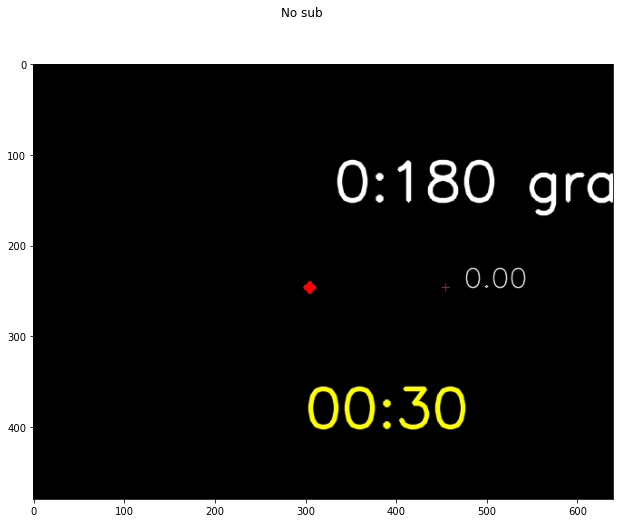

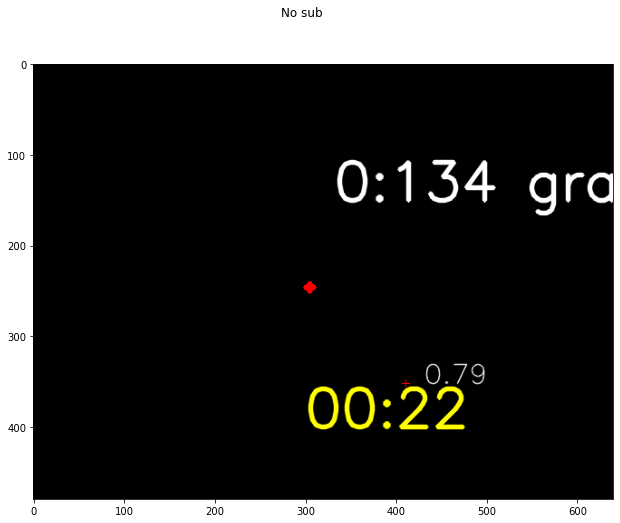

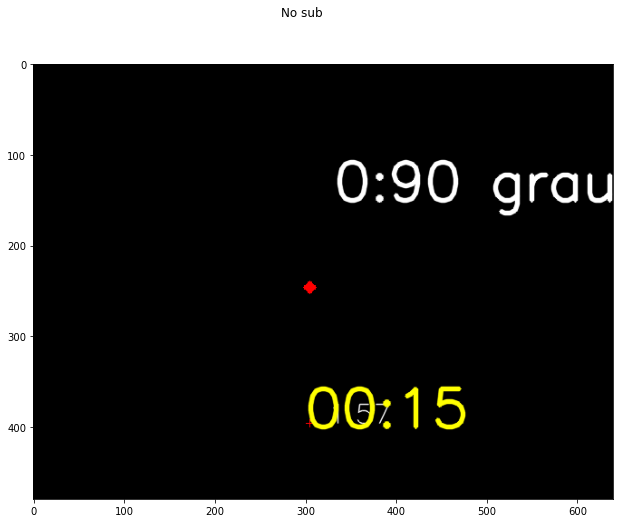

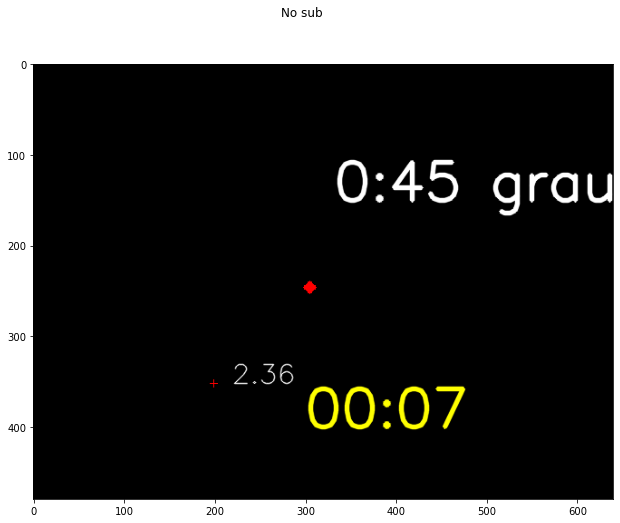

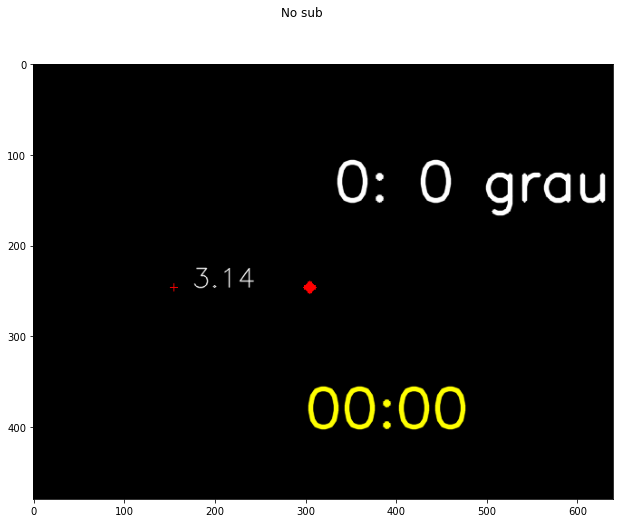

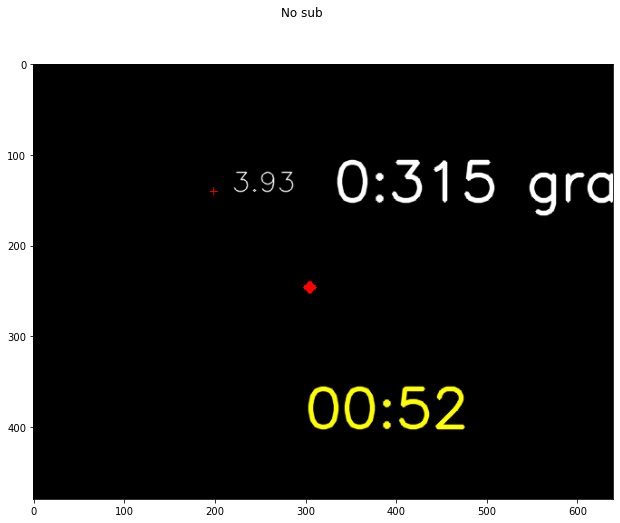

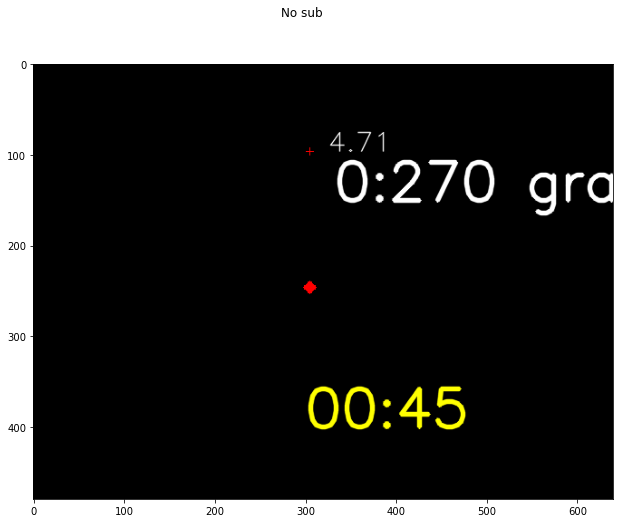

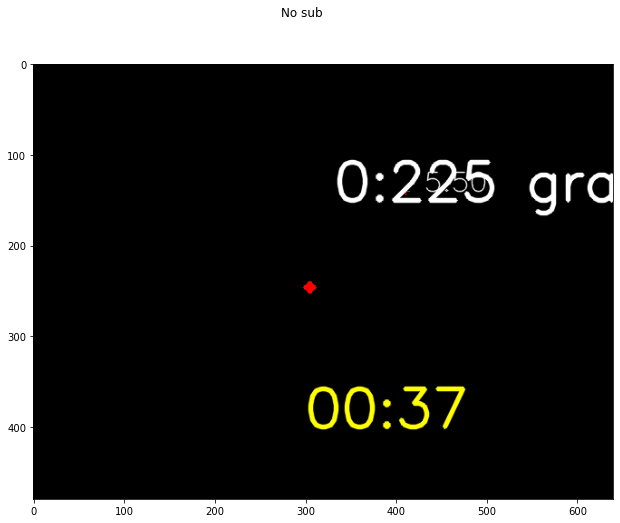

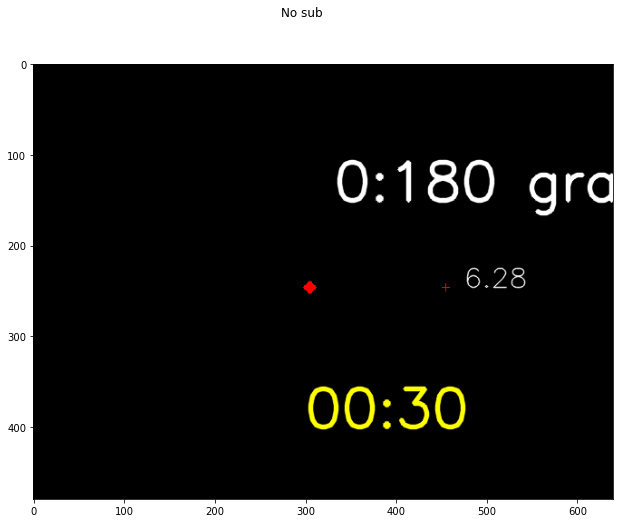

In [44]:
for i in range(len(points)):
    template[:]=0
    copy = template.copy()
    crosshair(copy, c, size=6, color=(255,255,255), width=2)    
    p = points[i]
    a = angles[i]
    text_cv(copy, (p[0]+20, p[1]), "{:.2f}".format(a))
    crosshair(copy, p, size=4, color=(0,0,255), width=1)       
    parte_final(copy, c, p)
    multiplot([copy])    
    

In [45]:
3*math.pi/2.0

4.71238898038469

In [46]:
math.radians(270)

4.71238898038469

In [47]:
! open .